In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score


In [18]:
feature_files = {
    "raw": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_raw.csv",
    "median": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_median_after_detrended.csv",
    "cleaned": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_outliercleaned.csv"
}

def load_features_for_clustering(path):
    df = pd.read_csv(path).dropna()

    # Save original labels for plotting comparison (optional)
    labels = df["Variable_Type"] if "Variable_Type" in df.columns else None

    # Drop string columns, keep only numeric features
    X = df.select_dtypes(include=[np.number])

    # Normalize features
    X_scaled = StandardScaler().fit_transform(X)

    return X_scaled, labels


In [15]:
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter

def kmeans_and_plot(X, labels, dataset_name, n_clusters=5):
    # Directory to save figures
    save_dir = "/home/devika/PhD/S1/Astroinformatics/Project/Results/K_means"
    os.makedirs(save_dir, exist_ok=True)

    # Run KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(X)

    # Silhouette Score
    score = silhouette_score(X, clusters)
    print(f"[{dataset_name.upper()}] Silhouette Score: {score:.3f}")

    # Reduce to 2D with PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_ratio_ * 100  # percentage

    # Map clusters to dominant true label if labels provided
    if labels is not None:
        df = {}
        for cluster_id in range(n_clusters):
            cluster_indices = np.where(clusters == cluster_id)[0]
            cluster_labels = labels.iloc[cluster_indices].tolist()  # <- iloc used here
            if cluster_labels:
                most_common_label = Counter(cluster_labels).most_common(1)[0][0]
            else:
                most_common_label = f"Cluster {cluster_id+1}"
            df[cluster_id] = most_common_label
    else:
        df = {i: f"Cluster {i+1}" for i in range(n_clusters)}

    # Plot clusters with mapped labels
    plt.figure(figsize=(10, 8))
    for cluster_id, label_name in df.items():
        indices = np.where(clusters == cluster_id)[0]
        color_val = plt.cm.tab10(cluster_id / n_clusters)
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1],
                    c=[color_val], label=label_name, s=20, alpha=0.7, edgecolors='none')
    plt.legend(title="Cluster Label")

    plt.title(f"K-Means Clusters (k={n_clusters}) - {dataset_name.upper()}\nSilhouette Score: {score:.3f}")
    plt.xlabel(f"Principal Component 1 ({explained_var[0]:.1f}% variance)")
    plt.ylabel(f"Principal Component 2 ({explained_var[1]:.1f}% variance)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/kmeans_clusters_{dataset_name}.pdf")
    plt.show()

    # Plot true labels if available
    if labels is not None:
        le = LabelEncoder()
        true_labels_encoded = le.fit_transform(labels)
        true_label_names = le.classes_

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels_encoded, cmap="tab20", s=20, alpha=0.7)

        handles = []
        for i, class_name in enumerate(true_label_names):
            color_val = plt.cm.tab20(i / len(true_label_names))
            handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                      label=class_name,
                                      markerfacecolor=color_val, markersize=8))
        plt.legend(handles=handles, title="True Variable Type")

        plt.title(f"True Variable Types - {dataset_name.upper()}")
        plt.xlabel(f"Principal Component 1 ({explained_var[0]:.1f}% variance)")
        plt.ylabel(f"Principal Component 2 ({explained_var[1]:.1f}% variance)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/true_labels_{dataset_name}.pdf")
        plt.show()


[RAW] Silhouette Score: 0.187


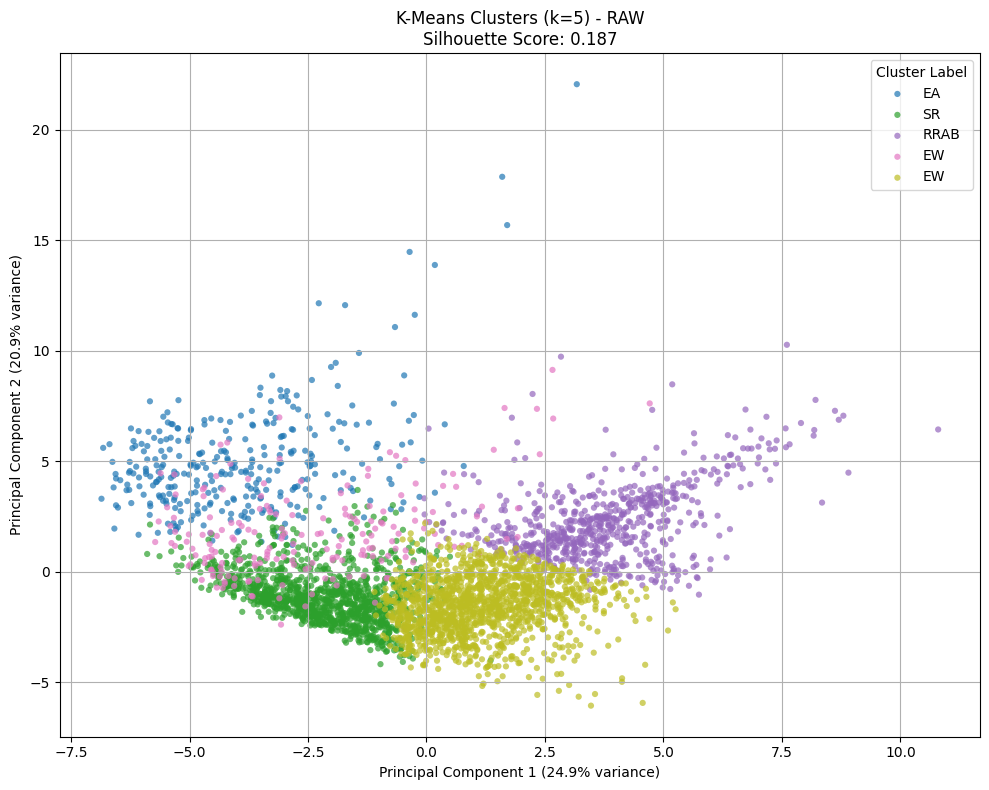

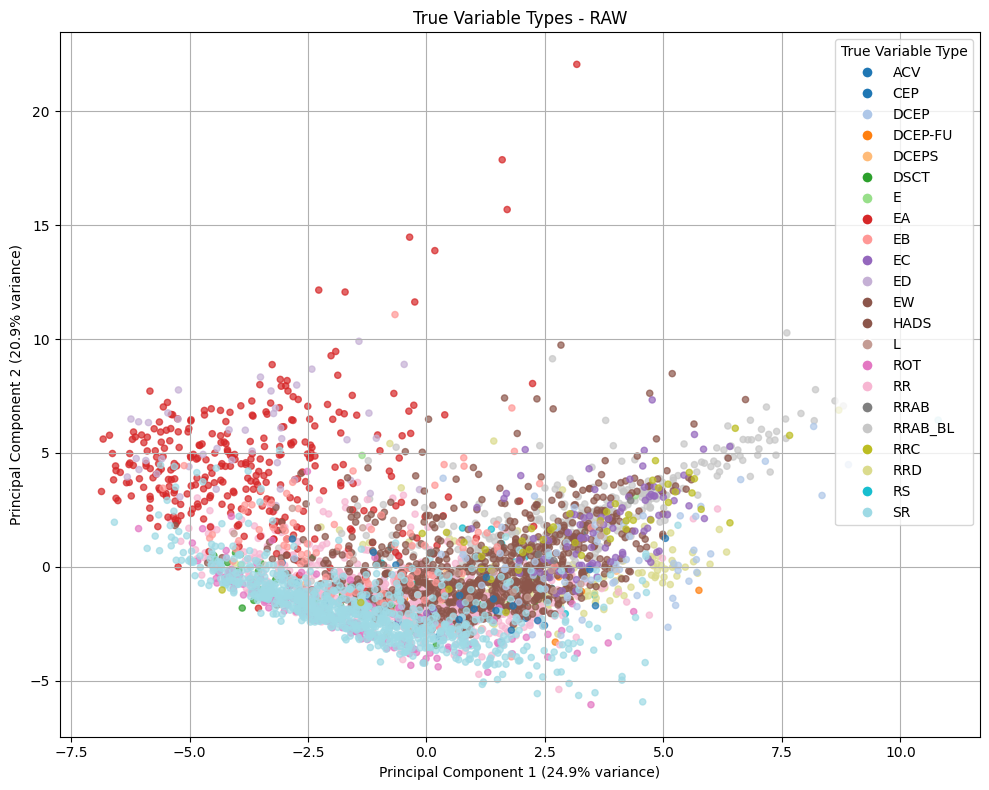

[MEDIAN] Silhouette Score: 0.188


/tmp/ipykernel_7348/1028937961.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster Label")


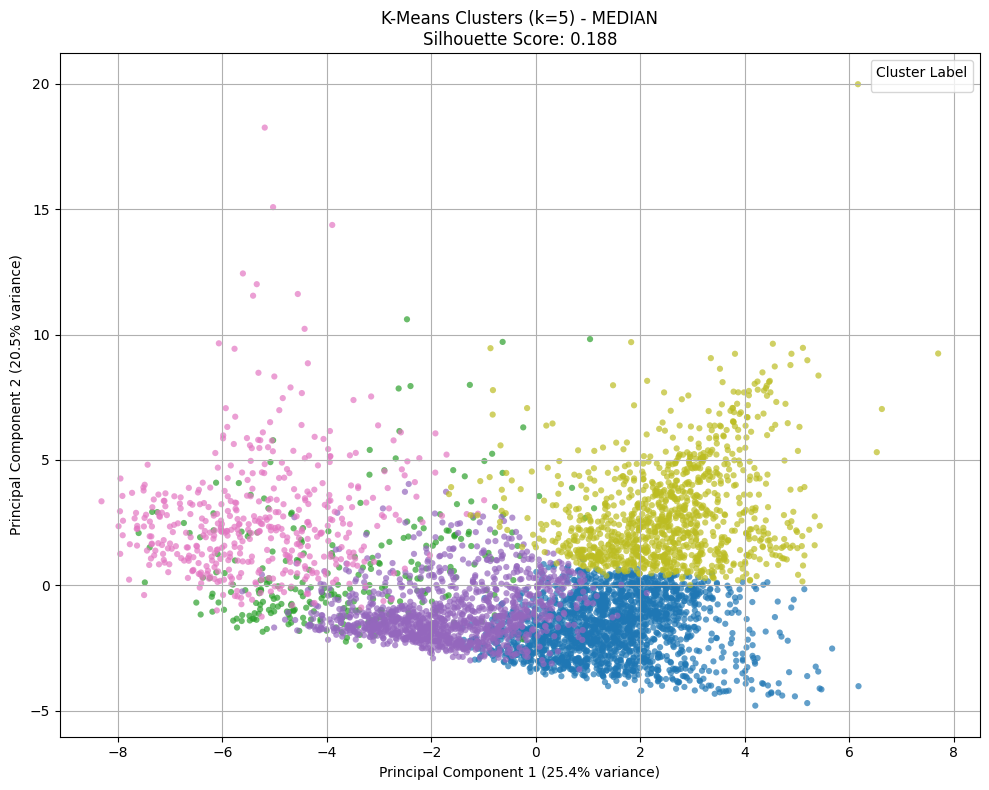

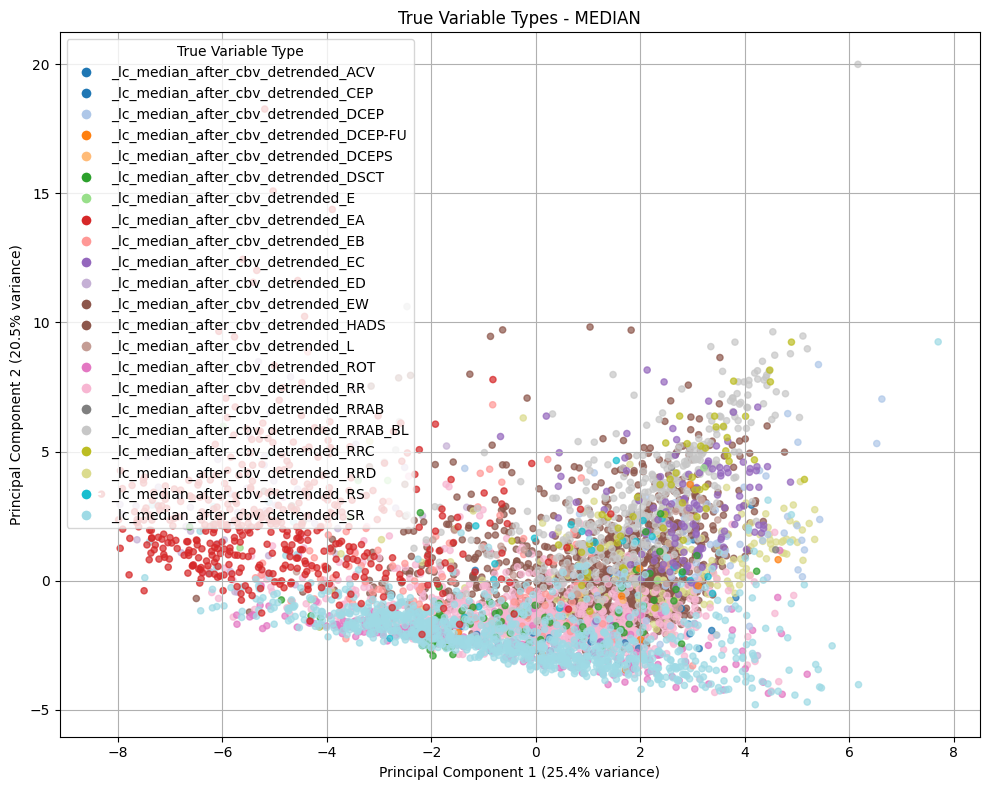

[CLEANED] Silhouette Score: 0.181


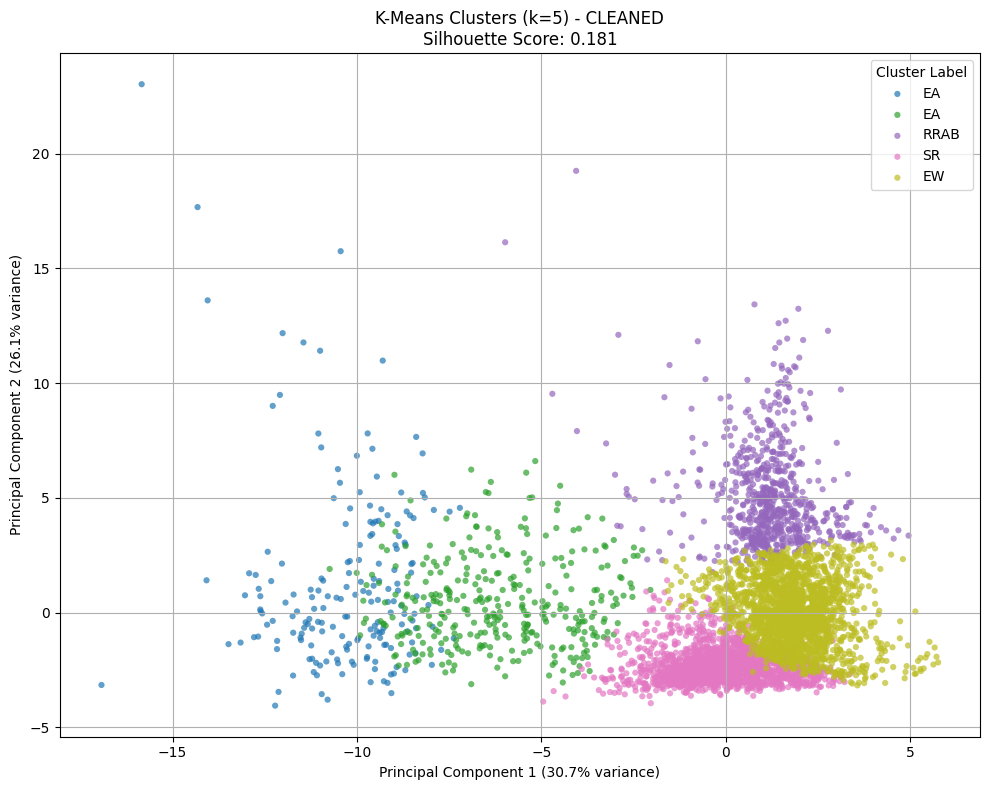

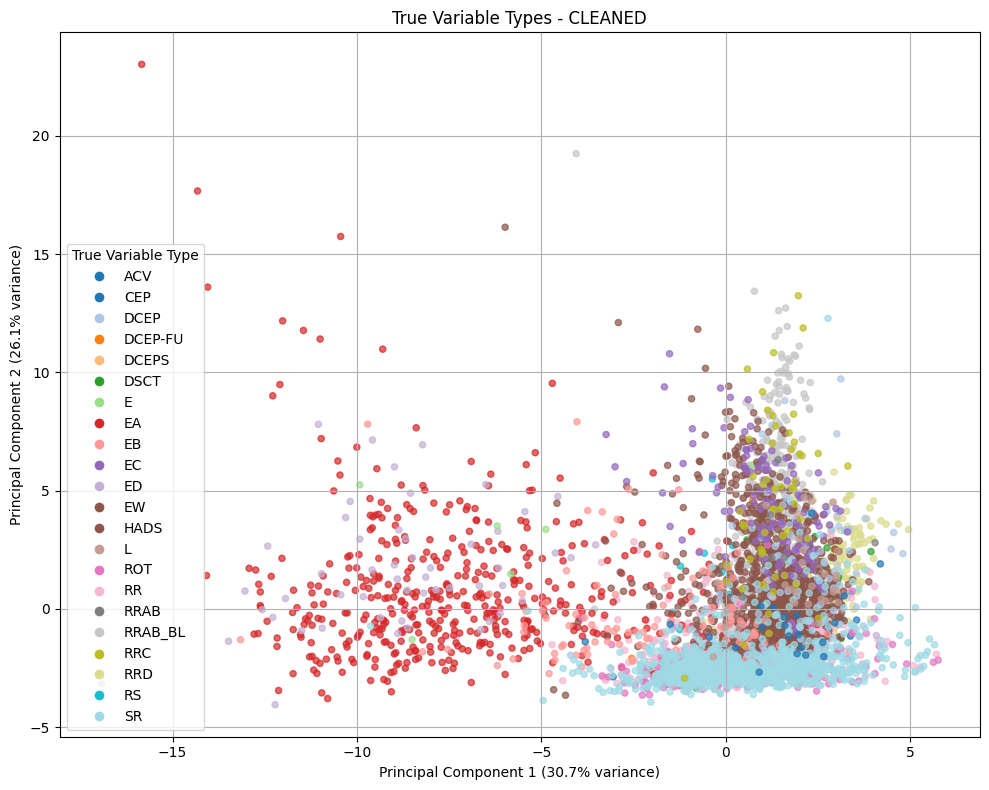

In [16]:
for name, path in feature_files.items():
    X_scaled, labels = load_features_for_clustering(path)
    kmeans_and_plot(X_scaled, labels, dataset_name=name, n_clusters=5)
